# Sentiment Analysis
Have to predict the columns 'SentimentTitle' and 'SentimentHeadline'

Sujit Shankar Jaishankar
sujit.jaishankar@gmail.com

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

import tensorflow
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding

import math
from math import exp
from keras import backend as K

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model

In [58]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


In [2]:
train = pd.read_csv("train_file.csv")
test = pd.read_csv("test_file.csv")

In [3]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [4]:
test.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
0,tFrqIR6Chj,Sliding Economy: FG fights back with N3trn TSA...,With the 2016 budget now passed by the Nationa...,BusinessDay,economy,2016-03-29 01:41:12,0,0,1
1,DVAaGErjlF,Microsoft shows how HoloLens can bring distant...,A recent Microsoft Research video shows how th...,Daily Mail,microsoft,2016-03-29 01:41:27,121,2,13
2,OT9UIZm5M2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",* Microsoft teamed with Bing to create TayTwee...,EURweb,microsoft,2016-03-29 01:47:00,12,1,0
3,lflGp3q2Fj,Flood of Central Bank Moves Can't Get World Ec...,Central bankers have managed to steer the worl...,Bloomberg via Yahoo! Finance,economy,2016-03-29 02:00:00,0,0,3
4,zDYG0SoovZ,USD/JPY: bears lining up on mixed U.S. economy...,"However, this streak of seven-day gains might ...",FXStreet,economy,2016-03-29 02:01:07,3,0,0


In [5]:
train.loc[0, 'Title']

'Obama Lays Wreath at Arlington National Cemetery'

In [6]:
train.loc[0, 'Headline']

'Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor'

In [7]:
pd.DataFrame(train.isnull().sum())

,0
IDLink,0
Title,0
Headline,0
Source,175
Topic,0
PublishDate,0
Facebook,0
GooglePlus,0
LinkedIn,0
SentimentTitle,0


There are null values present only for the Source column.

In [8]:
#Reset indexin order to create a new index [0 - len of dataframe]
nan_val = pd.DataFrame(train.isnull().sum())
nan_val = nan_val.reset_index()
nan_val

,index,0
0,IDLink,0
1,Title,0
2,Headline,0
3,Source,175
4,Topic,0
5,PublishDate,0
6,Facebook,0
7,GooglePlus,0
8,LinkedIn,0
9,SentimentTitle,0


In [9]:
train[train['Source'].isna()]

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
6,lKg2pImhCl,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",NaN,palestine,2016-02-28 14:03:00,0,0,0,0.000000,-0.005906
56,ZOKue2cqfO,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 09:29:00,0,0,0,0.000000,0.048546
111,JXfRvxs0R6,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 00:15:00,0,0,0,-0.243068,0.048546
350,A1YOXDsuOO,Human rights situation in Palestinian territor...,In a special meeting convened by the UN Human ...,NaN,palestine,2015-10-28 17:24:00,-1,-1,-1,-0.228299,-0.124931
409,fO2mYsUg5P,Japan Contributes $5.73M To UNRWA’s Food Assis...,"JERUSALEM, October 31, 2015 (WAFA) – The Japan...",NaN,palestine,2015-10-31 04:30:00,-1,-1,-1,0.166667,-0.042878
...,...,...,...,...,...,...,...,...,...,...,...
55482,FJZonPtvqe,"Monday, 28 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 04:35:00,0,0,0,-0.243068,0.068465
55483,NanKfuNzsO,"Saturday, 16 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 04:36:00,-1,-1,-1,0.000000,0.068465
55486,ovFBb4XFt4,"Sunday, 17 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 05:07:00,-1,-1,-1,0.000000,0.068465
55620,H2PlLqiX9U,"Tuesday, 29 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 14:06:00,0,0,0,-0.243068,0.068465


In [10]:
train.dropna(inplace = True)

In [11]:
pd.DataFrame(test.isnull().sum())

,0
IDLink,0
Title,0
Headline,0
Source,101
Topic,0
PublishDate,0
Facebook,0
GooglePlus,0
LinkedIn,0


In [12]:
test[test['Source'].isna()]

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
78,tgkeH242IX,"Tuesday, 19 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-29 07:24:00,-1,-1,-1
207,6EnfIIM2XK,"Wednesday, 30 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-29 14:10:00,0,0,0
456,QVFvknH8BH,"Thursday, 21 Apr 2016","RAMALLAH, March 30, 2016 (WAFA) – On the occas...",NaN,palestine,2016-03-30 02:36:00,-1,-1,-1
469,ssRPV1RQKA,"Wednesday, 30 Mar 2016","RAMALLAH, March 30, 2016 (WAFA) – On the occas...",NaN,palestine,2016-03-30 03:37:00,-1,-1,-1
514,jZ35MMRYnw,"Wednesday, 30 Mar 2016","RAMALLAH, March 30, 2016 (WAFA) – On the 40 th...",NaN,palestine,2016-03-30 06:51:00,0,0,0
...,...,...,...,...,...,...,...,...,...
26920,KjltvY9p6K,May Economy Watchers Survey:Expectations index...,The latest announced May Economy Watchers Surv...,NaN,economy,2016-06-08 19:13:00,-1,0,0
26962,ycqBL8nI3c,May Economy Watchers Survey:Current Trends Ind...,The latest announced May Economy Watchers Surv...,NaN,economy,2016-06-08 22:10:00,-1,0,0
29254,o9lTYSMTJe,Microsoft Announces Quarterly Div of US36 Cent...,Microsoft announced that the quarterly dividen...,NaN,microsoft,2016-06-14 22:11:00,-1,0,0
30545,EMy4yLPi0I,U.S. California Surpasses France as World's 6t...,California is now the sixth-largest economy in...,NaN,economy,2016-06-17 21:59:00,0,0,0


There are 101 NaN values in the test dataset that will require some imputation. Mean imputation is implemented here.


In [13]:
#test['Source'].fillna(value = test['Source'].mean(), inplace = True)

## Exploratory Data Analysis

In [14]:
sns.set(style = 'darkgrid', palette = 'Set1')

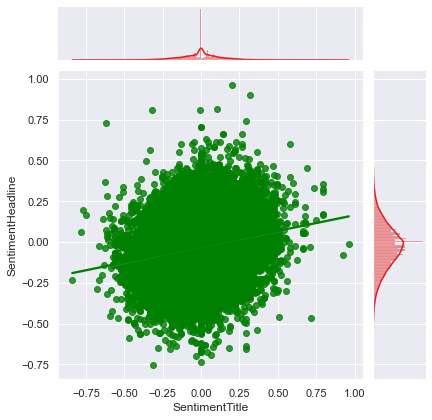

In [15]:
p = sns.jointplot(x='SentimentTitle',y='SentimentHeadline', data = train, kind = 'reg', 
                  joint_kws={'color':'green'})
plt.show()

The line across is a regular linear regression fit to the two features. 

Text(0.5, 1.0, 'Correlation Matrix')

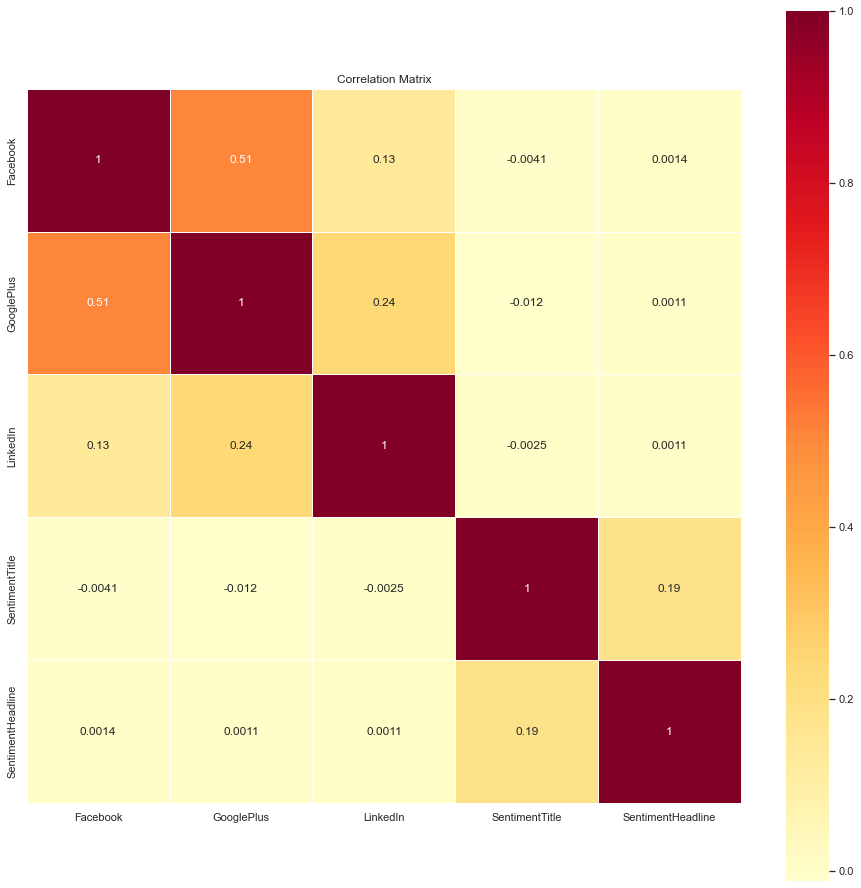

In [16]:
plt.figure(figsize = (16,16))
fig = sns.heatmap(train[['Facebook','GooglePlus','LinkedIn','SentimentTitle','SentimentHeadline']].corr(), square = True, cmap = 'YlOrRd', linewidths = 0.5, linecolor = 'w', annot = True)
plt.title('Correlation Matrix')

## News Sentiment Using Bidirectional LSTM based on GloVe

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SUJIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# Read in the glove embedded pretrained files directly from StanfordNLP
# Will first test on 6B tokens and 50D vectors
# Then may try a bigger corpora 

In [19]:
# 1. GloVe Dataset: https://www.kaggle.com/watts2/glove6b50dtxt
# 2. Alternate bigger corpora: https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
# Currently Using: 2
index_embed = dict()
fin = open('glove.42B.300D.txt', encoding = "utf-8")
for _ in fin:
    vals = _.split()
    word = vals[0]
    coef = np.asarray(vals[1:], dtype='float32')
    index_embed[word] = coef
fin.close()

In [20]:
test.describe()

,Facebook,GooglePlus,LinkedIn
count,37288.000000,37288.000000,37288.000000
mean,84.832654,2.895516,19.928181
std,420.063477,13.538942,225.443395
min,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,28.000000,2.000000,4.000000
max,16598.000000,1016.000000,20341.000000


In [21]:
X_train_title = train.loc[ : , 'Title'].values
y_train_title = train.loc[ : , ['SentimentTitle']].values

X_train_headline = train.loc[ : , 'Headline'].values
y_train_headline = train.loc[ : , ['SentimentHeadline']].values

X_test_title = test.loc[ : , 'Title'].values
X_test_headline = test.loc[ : , 'Headline'].values

In [22]:
# Now we need to extract the test values for title and headline
# Convert to dataframe for processing.

title_df = pd.DataFrame()
title_df['X_train_title'] = X_train_title
title_df['y_train_title'] = y_train_title

headline_df = pd.DataFrame()
headline_df['X_train_headline'] = X_train_headline
headline_df['y_train_headline'] = y_train_headline

test_df = pd.DataFrame()
test_df['X_test_title'] = X_test_title
test_df['X_test_headline'] = X_test_headline

The function below is to convert all text to lower case and remove any occurence of a non-ASCII character. 
Furthermore, stopwords from nltk is used to remove useless words such as 'ours', 'ourselves' etc.

In [23]:
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [24]:
def text_preprocess(text):
    text = text.lower() # Convert to lower case; uncased word embedding
    # Replace non-ASCII characters with space
    text = re.sub(r'[^\x00-\x7F]+', ' ', text) 
    words = text.split()
    words = filter(lambda x: x[0] != '@', text.split())
    words = [word for word in words if word not in set(stopwords.words('english'))]
    text = " ".join(words)
    return text

In [25]:
# Takes a moment
title_df['X_train_title'] = title_df.X_train_title.apply(text_preprocess)
display(title_df.head())

,X_train_title,y_train_title
0,obama lays wreath arlington national cemetery,0.000000
1,look health chinese economy,0.208333
2,nouriel roubini: global economy back 2008,-0.425210
3,finland gdp expands q4,0.000000
4,"tourism, govt spending buoys thai economy january",0.000000


In [26]:
headline_df['X_train_headline'] = headline_df.X_train_headline.apply(text_preprocess)
display(headline_df.head())

,X_train_headline,y_train_headline
0,obama lays wreath arlington national cemetery....,-0.053300
1,"tim haywood, investment director business-unit...",-0.156386
2,"nouriel roubini, nyu professor chairman roubin...",0.139754
3,finland's economy expanded marginally three mo...,0.026064
4,tourism public spending continued boost econom...,0.141084


In [27]:
test_df['X_test_title'] = test_df.X_test_title.apply(text_preprocess)
test_df['X_test_headline'] = test_df.X_test_headline.apply(text_preprocess)
display(test_df.head())

,X_test_title,X_test_headline
0,sliding economy: fg fights back n3trn tsa funds,2016 budget passed national assembly n3trillio...
1,microsoft shows hololens bring distant family ...,recent microsoft research video shows $3000 au...
2,"microsoft twitter robot praises hitler, trump ...","* microsoft teamed bing create taytweets, acco..."
3,flood central bank moves can't get world econo...,central bankers managed steer world economy cl...
4,usd/jpy: bears lining mixed u.s. economy outlook,"however, streak seven-day gains might end mark..."


In [28]:
#Tokenize and encode data for Title and Headline columns
title_max_len = title_df.X_train_title.apply(lambda x: len(x.split())).max()
title_token = Tokenizer()
title_token.fit_on_texts(title_df.X_train_title)
title_vocab_size = len(title_token.word_index) + 1

title_encoded = title_token.texts_to_sequences(title_df.X_train_title)
title_padded = pad_sequences(title_encoded, maxlen = title_max_len, padding = 'post')

title_vocab_size = len(title_token.word_index) + 1


In [29]:
# Create corresponding embedding matrix
title_embedding_matrix = np.zeros((title_vocab_size, 300))
for word, x in title_token.word_index.items():
    tembedding_vector = index_embed.get(word)
    if tembedding_vector is not None:
        title_embedding_matrix[x] = tembedding_vector

In [30]:
headline_max_len = headline_df.X_train_headline.apply(lambda x: len(x.split())).max()
headline_token = Tokenizer()
headline_token.fit_on_texts(headline_df.X_train_headline)
headline_vocab_size = len(headline_token.word_index) + 1

headline_encoded = headline_token.texts_to_sequences(headline_df.X_train_headline)
headline_padded = pad_sequences(headline_encoded, maxlen = headline_max_len, padding = 'post')

headline_vocab_size = len(headline_token.word_index) + 1

In [31]:
headline_embedding_matrix = np.zeros((headline_vocab_size, 300))
for word, x in headline_token.word_index.items():
    hembedding_vector = index_embed.get(word)
    if hembedding_vector is not None:
        headline_embedding_matrix[x] = hembedding_vector

In [32]:
test_title_max_len = test_df.X_test_title.apply(lambda x: len(x.split())).max()
test_title_token = Tokenizer()
test_title_token.fit_on_texts(test_df.X_test_title)
test_title_vocab_size = len(test_title_token.word_index) + 1

test_title_encoded = test_title_token.texts_to_sequences(test_df.X_test_title)
test_title_padded = pad_sequences(test_title_encoded, maxlen = test_title_max_len, padding = 'post')

test_title_vocab_size = len(test_title_token.word_index) + 1


In [33]:
test_headline_max_len = test_df.X_test_headline.apply(lambda x: len(x.split())).max()
test_headline_token = Tokenizer()
test_headline_token.fit_on_texts(test_df.X_test_headline)
test_headline_vocab_size = len(test_headline_token.word_index) + 1

test_headline_encoded = test_headline_token.texts_to_sequences(test_df.X_test_headline)
test_headline_padded = pad_sequences(test_headline_encoded, maxlen = test_headline_max_len, padding = 'post')

test_headline_vocab_size = len(test_headline_token.word_index) + 1


In [34]:
x_train_title, x_valid_title, Y_train_title, y_valid_title = train_test_split(title_padded, y_train_title, shuffle = True, test_size = 0.1)
x_train_headline, x_valid_headline, Y_train_headline, y_valid_headline = train_test_split(headline_padded, y_train_headline, shuffle = True, test_size = 0.1)

In [35]:
def mod_tanh(x):
    return K.tanh(0.6*x)

## Model to predict Title

In [50]:
title_model = Sequential()
title_model.add(Embedding(title_vocab_size, 300, input_length = title_max_len, weights = [title_embedding_matrix], trainable = True))
title_model.add(Bidirectional(LSTM(20, return_sequences = True)))
title_model.add(Dropout(0.3))
title_model.add(BatchNormalization())
title_model.add(Bidirectional(LSTM(20, return_sequences = True)))
title_model.add(Dropout(0.3))
title_model.add(BatchNormalization())
title_model.add(Bidirectional(LSTM(20)))
title_model.add(Dropout(0.3))
title_model.add(BatchNormalization())
title_model.add(Dense(64, activation = 'relu'))
title_model.add(Dense(64, activation = 'relu'))
title_model.add(Dense(1, activation = mod_tanh))
title_model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse', 'mae'])



In [61]:
print(title_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 19, 300)           8434800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 19, 40)            51360     
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 40)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 19, 40)            160       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 19, 40)            9760      
_________________________________________________________________
dropout_4 (Dropout)          (None, 19, 40)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 19, 40)           

In [60]:
tensorflow.keras.utils.plot_model(title_model, to_file='title_model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Model to predict Headline

In [62]:
headline_model = Sequential()
headline_model.add(Embedding(headline_vocab_size, 300, input_length = headline_max_len, weights = [headline_embedding_matrix], trainable=True))
headline_model.add(Bidirectional(LSTM(20, return_sequences=True)))
headline_model.add(Dropout(0.3))
headline_model.add(BatchNormalization())
headline_model.add(Bidirectional(LSTM(20, return_sequences=True)))
headline_model.add(Dropout(0.3))
headline_model.add(BatchNormalization())
headline_model.add(Bidirectional(LSTM(20)))
headline_model.add(Dropout(0.3))
headline_model.add(BatchNormalization())
headline_model.add(Dense(64, activation='relu'))
headline_model.add(Dense(64, activation='relu'))
headline_model.add(Dense(1, activation = mod_tanh))
headline_model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse', 'mae'])



In [64]:
print(headline_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 300)           12141300  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 60, 40)            51360     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 40)            0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 60, 40)            160       
_________________________________________________________________
bidirectional_7 (Bidirection (None, 60, 40)            9760      
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 40)            0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 40)           

In [63]:
plot_model(headline_model, to_file='headline_model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [39]:
with tensorflow.device('/device:GPU:0'):
    title_model.fit(x_train_title, Y_train_title, epochs = 20)

Epoch 1/20
1569/1569 [==============================] - 119s 73ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1052
Epoch 2/20
1569/1569 [==============================] - 114s 73ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0755
Epoch 3/20
1569/1569 [==============================] - 114s 72ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0620
Epoch 4/20
1569/1569 [==============================] - 114s 72ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0557
Epoch 5/20
1569/1569 [==============================] - 114s 73ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0505
Epoch 6/20
1569/1569 [==============================] - 114s 72ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0466
Epoch 7/20
1569/1569 [==============================] - 113s 72ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0422
Epoch 8/20
1569/1569 [==============================] - 113s 72ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0391
Epoch 9/20
1569/1569 [==============================] - 114s 72ms/step - loss: 0.0028 - 

In [40]:
with tensorflow.device('/device:GPU:0'):
    headline_model.fit(x_train_headline, Y_train_headline, epochs = 20)

Epoch 1/20
1569/1569 [==============================] - 199s 124ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1158
Epoch 2/20
1569/1569 [==============================] - 194s 124ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0887
Epoch 3/20
1569/1569 [==============================] - 194s 124ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0704
Epoch 4/20
1569/1569 [==============================] - 194s 123ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0620
Epoch 5/20
1569/1569 [==============================] - 194s 124ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0559
Epoch 6/20
1569/1569 [==============================] - 194s 123ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0504
Epoch 7/20
1569/1569 [==============================] - 194s 124ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0453
Epoch 8/20
1569/1569 [==============================] - 194s 123ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0415
Epoch 9/20
1569/1569 [==============================] - 194s 124ms/step - loss: 

In [41]:
title_valid_pred = title_model.predict(x_valid_title)

In [42]:
headline_valid_pred = headline_model.predict(x_valid_headline)

In [43]:
mae_title = mean_absolute_error(y_valid_title,title_valid_pred)

In [44]:
mae_headline = mean_absolute_error(y_valid_headline,headline_valid_pred)

In [45]:
score = 1-((0.4 * mae_title) + (0.6 * mae_headline))

In [46]:
score

0.9340902297640117

In [47]:
pred_title = title_model.predict(test_title_padded)

In [48]:
pred_headline = headline_model.predict(test_headline_padded)

In [49]:
submission = pd.DataFrame()

In [50]:
submission['IDLink'] = test['IDLink'].to_list()
submission['SentimentTitle'] = pred_title
submission['SentimentHeadline'] = pred_headline

In [51]:
submission.head()

,IDLink,SentimentTitle,SentimentHeadline
0,tFrqIR6Chj,0.033810,-0.094556
1,DVAaGErjlF,-0.094772,0.147475
2,OT9UIZm5M2,-0.075115,-0.088410
3,lflGp3q2Fj,-0.124870,0.025035
4,zDYG0SoovZ,-0.003223,-0.035367


In [52]:
submission.to_csv('submission.csv', index = False)